# Anomaly detection using LSTM autoencoder
The purpose of this experiment was to build a LSTM sequence-to-sequence autoencoder and use it for anomally detection on generated sound data.

The idea is to train autoencoder to encode the whole sequence (sequence of spectrogram columns) into a latent space of low dimension and let the decoder decode the whole sequence back from the latent dimension. Memorizing the whole sequence should be a challenging task and the hypothesis is that the decoder will fail to decode an anomaly (low probability even) so it should be detectable by comparing the decoder result with the input.

## Data preprocessing

First, some imports and loading routines:

In [1]:
import os
import pandas
import h5py

import librosa.core as libcore
import numpy as np
from scipy.ndimage.interpolation import zoom

import utils

%matplotlib inline
import matplotlib.pyplot as plt

def walk(path):
    for root, dirs, files in os.walk(path):
        for name in files:
            yield os.path.join(root, name), name

Set up constants. We are going to use spectrogram of generated anomaly dataset (Bigr) and do the following:

1. Load dataset into memory
1. Sample a SEQ_TIME long sequence at random position, TS_SIZE times
1. For each sample we will    
    - Add NOISE_SCALE big noise
    - Normalize it with the average power across the whole dataset
    - Compute a short-time fourier transform with N_FFT window
    - Take a logarithm from the real part within the frequency domain
    - Downsample to half size of the resulting image

In [23]:
SAMPLING_RATE = 44100
N_FFT = 1024
SEQ_TIME = 5
NOISE_SCALE = 1.0e-5

CHUNK_SIZE = SEQ_TIME * SAMPLING_RATE
HOP_LENGTH = N_FFT // 4
STFT_FPS = SAMPLING_RATE // HOP_LENGTH

WAV_FILE = '../data/raw/first.flac'

TS_SIZE = 2500

In [5]:
def sample_chunk(samples, power, position=None, size=CHUNK_SIZE):
        
    if position is None:
        position = int(np.random.uniform(high=len(samples) - size))    
    
    if NOISE_SCALE > 0:
        noise = np.random.normal(loc=0, scale=NOISE_SCALE, size=size)
        chunk = (samples[position : position + size] + noise) / power
    else:
        chunk = samples[position : position + size] / power        
    
    spectrum = np.log(np.abs(libcore.stft(chunk, n_fft=N_FFT)) + 1)[0 : N_FFT // 4] / 10.0        
    spectrum = zoom(spectrum, zoom=0.5)
    return spectrum

Now, load the dataset, get the average power and construct the training set

In [4]:
samples, _ = libcore.load(WAV_FILE, sr=SAMPLING_RATE)
power = np.mean(samples ** 2) * 0.5

In [24]:
training_set = np.array([sample_chunk(samples, power).T for i in range(TS_SIZE)])

This is an example of a training sequence:

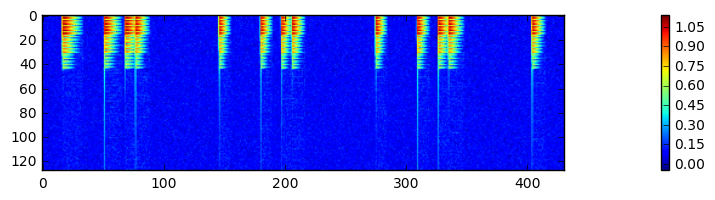

In [38]:
plt.figure(figsize=(25,2))
cax = plt.imshow(training_set[0].T)
plt.colorbar(cax)
plt.show()
plt.close()

## Model construction & training

We will use Keras for the model. The model consist of two parts: encoder and decoder.

The encoder is built with only one layer of GRU neurons and the decoder is built with two layers of the same size GRUs. The hypothesis here is that the encoding part is easier than the decoding part where the whole column must be carefully reconstructed to get low error on output. Empirical results are aligned with this hypothesis as one-layer-decoder model did not converge to the solution in a reasonable time (hundreds of epochs).

There is a *RepeatVector* layer in the middle that serves as a feature layer. The model reads the whole sequence (2D image) one by one column and encodes it to the encoder output. After encoding, the repeat vector will serve the same feature layer (encoder output) SEQ_LEN times to the decoder that will reproduce the input image again one by one column. Consequently, there's 1/440 compression ratio on the feature layer. 

In [10]:
from keras.layers import Input, Dense, LSTM, GRU
from keras.layers.core import RepeatVector
from keras.layers.wrappers import Bidirectional
from keras.models import Model

SEQ_LEN = (SEQ_TIME * STFT_FPS + 2) // 2
INPUT_DIM = (N_FFT // 4) // 2

inputs = Input(shape=(SEQ_LEN, INPUT_DIM))
enc_1 = GRU(128)(inputs)
features = RepeatVector(SEQ_LEN)(enc_1)
dec_0 = GRU(128, return_sequences=True)(features)
dec_1 = GRU(INPUT_DIM, return_sequences=True)(dec_0)
autoencoder = Model(inputs, dec_1)
autoencoder.summary()

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 960M (CNMeM is disabled, cuDNN 5103)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 431, 128)      0                                            
____________________________________________________________________________________________________
gru_1 (GRU)                      (None, 128)           98688       input_1[0][0]                    
____________________________________________________________________________________________________
repeatvector_1 (RepeatVector)    (None, 431, 128)      0           gru_1[0][0]                      
____________________________________________________________________________________________________
gru_2 (GRU)                      (None, 431, 128)      98688       repeatvector_1[0][0]             
___________________________________________________________________________________________

As for a regression model, we will train it with RMSProp optimization and mean square error loss.

The actual training took a very long time (several hundreds of epochs) so the following log is only for clarity.

In [11]:
autoencoder.compile(optimizer='rmsprop', loss='mse')

In [12]:
autoencoder.load_weights('../output/gru2- 29-0.01.hdf')

In [41]:
from keras.callbacks import ModelCheckpoint

model_cb = ModelCheckpoint('../output/gru3-{epoch:d}-{val_loss:.3f}.hdf', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=10)
history = autoencoder.fit(training_set, training_set, nb_epoch=10, validation_split=0.1, callbacks=[model_cb])

Train on 2250 samples, validate on 250 samples
Epoch 1/10
2250/2250 [==============================] - 190s - loss: 0.0089 - val_loss: 0.0099
Epoch 2/10
2250/2250 [==============================] - 185s - loss: 0.0088 - val_loss: 0.0098
Epoch 3/10
2250/2250 [==============================] - 184s - loss: 0.0087 - val_loss: 0.0107
Epoch 4/10
2250/2250 [==============================] - 195s - loss: 0.0088 - val_loss: 0.0085
Epoch 5/10
2250/2250 [==============================] - 196s - loss: 0.0097 - val_loss: 0.0125
Epoch 6/10
2250/2250 [==============================] - 197s - loss: 0.0088 - val_loss: 0.0096
Epoch 7/10
2250/2250 [==============================] - 202s - loss: 0.0087 - val_loss: 0.0090
Epoch 8/10
2250/2250 [==============================] - 202s - loss: 0.0086 - val_loss: 0.0116
Epoch 9/10
2250/2250 [==============================] - 195s - loss: 0.0086 - val_loss: 0.0062
Epoch 10/10
2250/2250 [==============================] - 190s - loss: 0.0087 - val_loss: 0.0079


## Signal reconstruction & validation
This is how the reconstruction looks like. 

We can see that at the beginning, the decoder did a pretty good job on picking up the right phase of the input signal and producing accureate result, however, further in time, errors get accumulated and the reconstruction becomes blurry.

In [13]:
pred = autoencoder.predict(np.expand_dims(training_set[0], axis=0))[0]

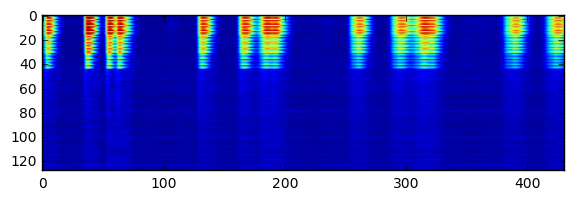

In [45]:
plt.figure(figsize=(20,2))
cax = plt.imshow(pred.T)
plt.show()
plt.close()

To fix this behavior, we are going to limit the sequence length and use only the first 25% of decoded image (sampling from the input dataset with 75% overlay).

This *sliding window* samples are then feeded to the learned autoencoder producing a long sequence of reconstructed output.

In [ ]:
batch_size = 15
batch_input = sample_chunk(samples, power, position=0, size=CHUNK_SIZE * (batch_size + 1))
print(batch_input.shape)

stride = SEQ_LEN // 4 

batch = np.array([batch_input[:, i * stride : i * stride + SEQ_LEN].T for i in range(batch_size * 4)])
print(batch.shape)
prediction = autoencoder.predict(batch)

batch_output = None
for i, chunk in enumerate(prediction):            
    if batch_output is None:        
        batch_output = np.array(chunk[: stride + 10])
    else:                
        batch_output = np.concatenate((batch_output, chunk[10 : stride + 10]))

This is how the resulting prediction on long sequence of concatenated model outputs looks like:

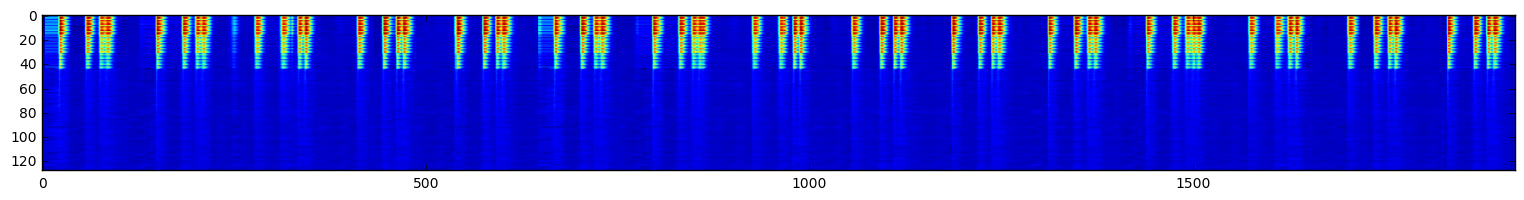

In [22]:
plt.figure(figsize=(19,2))
cax = plt.imshow(batch_output.T[:, 4500 : stride * 4 * batch_size], aspect='auto')
plt.show()
plt.close()

... and for comparison, this is how the original input with two anomalies looks like:

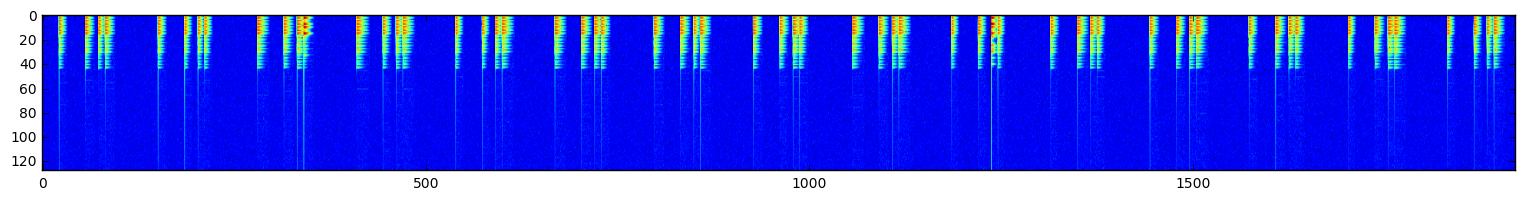

In [21]:
plt.figure(figsize=(19,2))
cax = plt.imshow(batch_input[:, 4500 : stride * 4 * batch_size], aspect='auto')
plt.show()
plt.close()

Now, we can compute square error over the whole image and see if we can spot anomalies in it.

The upper image shows point-wise square error as a 2D image, the lower plot shows sum of errors per column.

In [19]:
mse = np.abs(batch_input[:, 4500 : stride * 4 * batch_size] - batch_output.T[:, 4500 : stride * 4 * batch_size])
mse_sum = np.sum(mse, axis=0)

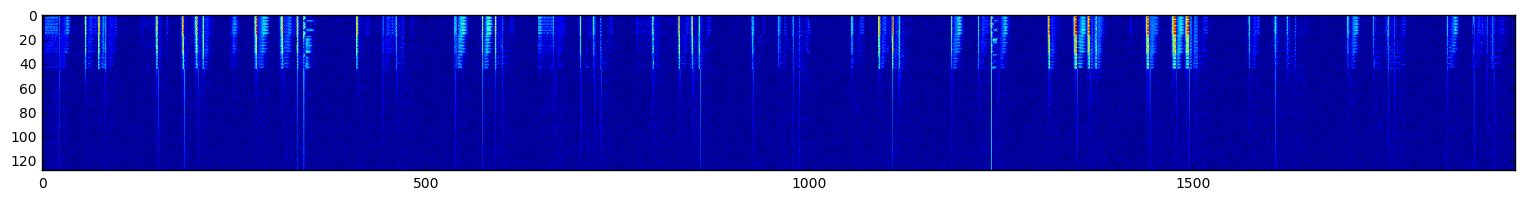

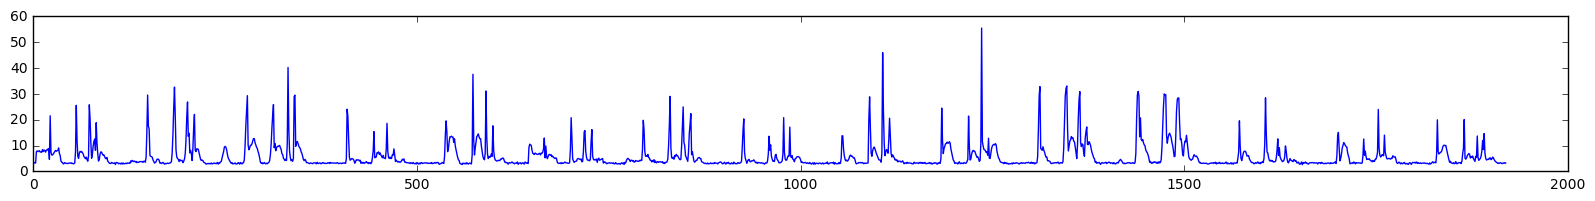

In [20]:
plt.figure(figsize=(19,2))
cax = plt.imshow(mse, aspect='auto')
plt.show()
plt.close()

plt.figure(figsize=(19.8,2))
plt.plot(mse_sum)
plt.show()
plt.close()

## Conclusions & suggested continuation

Although the reconstruction looks very accurate and the model was able to store all necesary information for reconstruction into 128 floating point numbers (1/110 compression ratio given that we use only the first quater of the reconstruction), the resulting error measure cannot be use to spot anomalies easily. There are peaks where anomalies appear but the model is not accurate enough to threshold anomalies from the error function.

The most of false positives are caused by inaccurate capture of leading edge inside the signal where even a very small delay causes a high peak in the error function. There are several approaches that may fix this problem:

1. Increase the resolution of the input image
    - Training examples was artificially downsampled to get smaller inputs and thus faster learning. The model may acquire better precision if this downsampling is ommited, but the learning time gets longer.
2. Enlarge the latent space of the model
    - Ecoding the sequence into 128 dimensions may be to difficult for the model and we can loose precision here. However, larger lantent dimension goes againt the general idea of autoencoder-based anomally detection.
3. Use different generative model
    - Following this article (https://arxiv.org/pdf/1703.05921.pdf), one can use GAN model with modified loss functions for detection anomalies in texture-like images. We should be able to replicate this research and use it with spectrogram images instead.